In [45]:
import numpy as np
import scipy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.interpolate import lagrange
import numpy.polynomial.polynomial as poly

from math import sqrt

---

## Interpolation Polynomials

In [46]:
def even_samples(num_points):
    return np.linspace(0,np.pi,num_points)

def ran_samples(num_points):
    return np.random.rand(num_points)*np.pi

def trig(x):
    return  2*np.cos(x)+np.sin(2*x)+np.sqrt(x)



In [47]:
x_ran = ran_samples(8)
x_even = even_samples(8)

y_ran = trig(x_ran)
y_even = trig(x_even)

In [48]:
f_even = lagrange(x_even, y_even)
f_ran = lagrange(x_ran, y_ran)

In [49]:
def La_pol(x,y,o):
    sum = 0
    for i in range(len(x)):
        prod = y[i]
        for j in range(len(x)):
            if i!=j:
                prod = prod*(o-x[j])/(x[i]-x[j])
        sum = sum + prod
    return sum

In [50]:
f_even = La_pol(x_even,y_even,np.linspace(min(x_even),max(x_even),500))
f_ran = La_pol(x_ran,y_ran,np.linspace(min(x_ran),max(x_ran),500))

#prange_even = np.linspace(min(x_even),max(x_even),500)
#prange_ran = np.linspace(min(x_ran),max(x_ran),500)

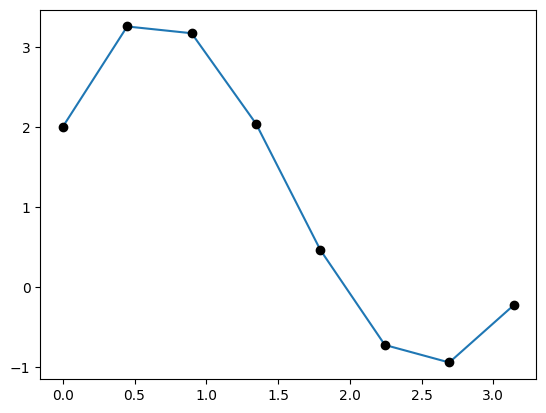

In [51]:
plt.plot(even_samples(8),La_pol(x_even,y_even,even_samples(8)))
plt.plot(x_even, y_even, 'ko')
plt.show()

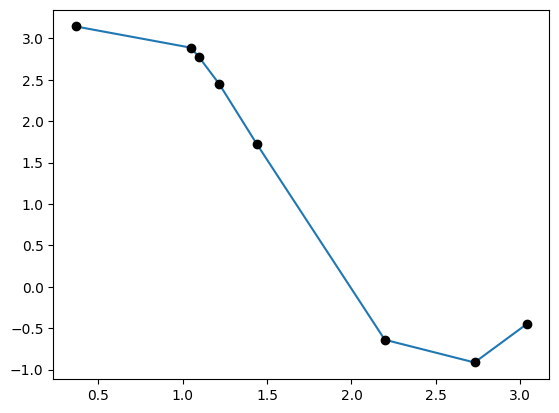

In [67]:
x = ran_samples(8)
x = np.sort(x)
y = trig(x)

plt.plot(x,La_pol(x,y,x))
plt.plot(x,y, 'ko')
plt.show()

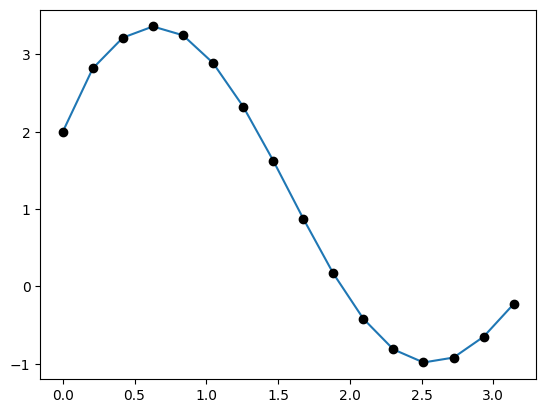

In [53]:
plt.plot(even_samples(16),La_pol(even_samples(16),trig(even_samples(16)),even_samples(16)))
plt.plot(even_samples(16),trig(even_samples(16)), 'ko')
plt.show()

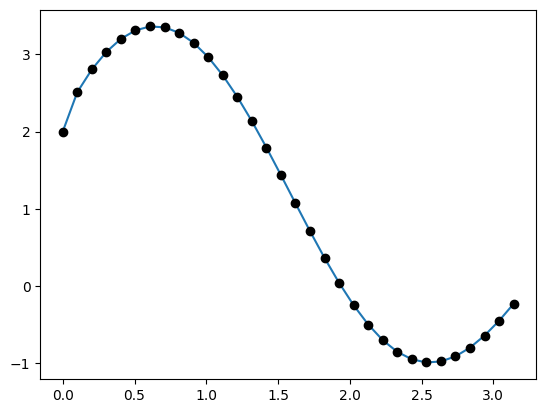

In [54]:
plt.plot(even_samples(32),La_pol(even_samples(32),trig(even_samples(32)),even_samples(32)))
plt.plot(even_samples(32),trig(even_samples(32)), 'ko')
plt.show()

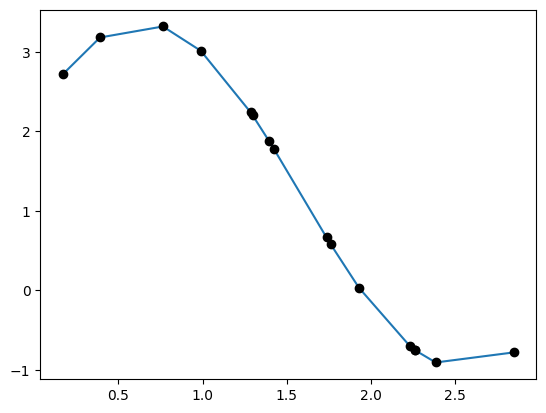

In [65]:
x = ran_samples(16)
x = np.sort(x)
y = trig(x)

plt.plot(x,La_pol(x,y,x))
plt.plot(x,y, 'ko')
plt.show()

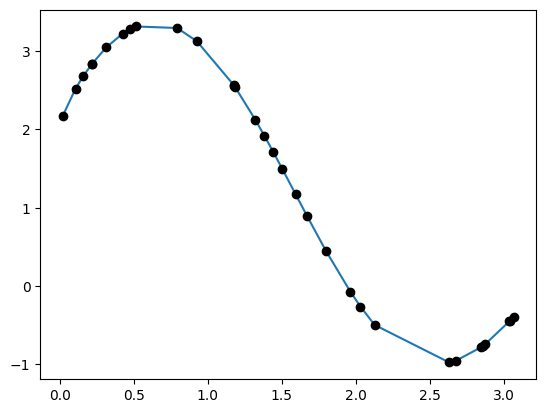

In [56]:
x = ran_samples(32)
x = np.sort(x)
y = trig(x)

plt.plot(x,La_pol(x,y,x))
plt.plot(x,y, 'ko')
plt.show()

---

## Splines

In [57]:
def cubic_interp1d(x0, x, y):
    """
    Interpolate a 1-D function using cubic splines.
      x0 : a float or an 1d-array
      x : (N,) array_like
          A 1-D array of real/complex values.
      y : (N,) array_like
          A 1-D array of real values. The length of y along the
          interpolation axis must be equal to the length of x.

    Implement a trick to generate at first step the cholesky matrice L of
    the tridiagonal matrice A (thus L is a bidiagonal matrice that
    can be solved in two distinct loops).

    additional ref: www.math.uh.edu/~jingqiu/math4364/spline.pdf
    """
    x = np.asfarray(x)
    y = np.asfarray(y)

    # remove non finite values
    # indexes = np.isfinite(x)
    # x = x[indexes]
    # y = y[indexes]

    # check if sorted
    if np.any(np.diff(x) < 0):
        indexes = np.argsort(x)
        x = x[indexes]
        y = y[indexes]

    size = len(x)

    xdiff = np.diff(x)
    ydiff = np.diff(y)

    # allocate buffer matrices
    Li = np.empty(size)
    Li_1 = np.empty(size-1)
    z = np.empty(size)

    # fill diagonals Li and Li-1 and solve [L][y] = [B]
    Li[0] = sqrt(2*xdiff[0])
    Li_1[0] = 0.0
    B0 = 0.0 # natural boundary
    z[0] = B0 / Li[0]

    for i in range(1, size-1, 1):
        Li_1[i] = xdiff[i-1] / Li[i-1]
        Li[i] = sqrt(2*(xdiff[i-1]+xdiff[i]) - Li_1[i-1] * Li_1[i-1])
        Bi = 6*(ydiff[i]/xdiff[i] - ydiff[i-1]/xdiff[i-1])
        z[i] = (Bi - Li_1[i-1]*z[i-1])/Li[i]

    i = size - 1
    Li_1[i-1] = xdiff[-1] / Li[i-1]
    Li[i] = sqrt(2*xdiff[-1] - Li_1[i-1] * Li_1[i-1])
    Bi = 0.0 # natural boundary
    z[i] = (Bi - Li_1[i-1]*z[i-1])/Li[i]

    # solve [L.T][x] = [y]
    i = size-1
    z[i] = z[i] / Li[i]
    for i in range(size-2, -1, -1):
        z[i] = (z[i] - Li_1[i-1]*z[i+1])/Li[i]

    # find index
    index = x.searchsorted(x0)
    np.clip(index, 1, size-1, index)

    xi1, xi0 = x[index], x[index-1]
    yi1, yi0 = y[index], y[index-1]
    zi1, zi0 = z[index], z[index-1]
    hi1 = xi1 - xi0

    # calculate cubic
    f0 = zi0/(6*hi1)*(xi1-x0)**3 + \
         zi1/(6*hi1)*(x0-xi0)**3 + \
         (yi1/hi1 - zi1*hi1/6)*(x0-xi0) + \
         (yi0/hi1 - zi0*hi1/6)*(xi1-x0)
    return f0

In [58]:
cubic_interp1d([x_even[0]],x_even,y_even)

array([2.])

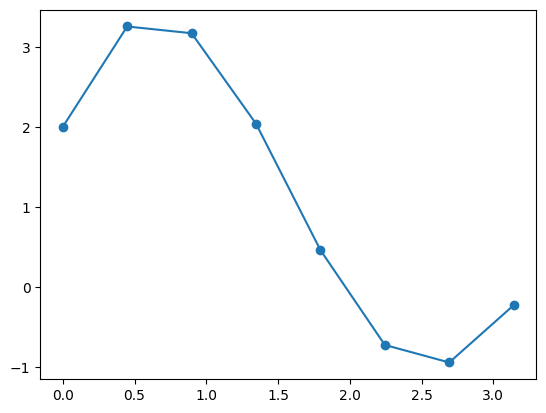

In [59]:
x = np.linspace(0, 10, 11)
y = np.sin(x)
plt.scatter(x_even, y_even)

x_new = np.linspace(0, 10, 201)
plt.plot(x_even, cubic_interp1d(x_even,x_even,y_even))

plt.show()

In [60]:
def cubic_interpolate(x0, x, y):

    xdiff = np.diff(x)
    dydx = np.diff(y)
    dydx /= xdiff

    n = size = len(x)

    w = np.empty(n-1, float)
    z = np.empty(n, float)

    w[0] = 0.
    z[0] = 0.
    for i in range(1, n-1):
        m = xdiff[i-1] * (2 - w[i-1]) + 2 * xdiff[i]
        w[i] = xdiff[i] / m
        z[i] = (6*(dydx[i] - dydx[i-1]) - xdiff[i-1]*z[i-1]) / m
    z[-1] = 0.

    for i in range(n-2, -1, -1):
        z[i] = z[i] - w[i]*z[i+1]

    # find index (it requires x0 is already sorted)
    index = x.searchsorted(x0)
    np.clip(index, 1, size-1, index)

    xi1, xi0 = x[index], x[index-1]
    yi1, yi0 = y[index], y[index-1]
    zi1, zi0 = z[index], z[index-1]
    hi1 = xi1 - xi0

    # calculate cubic
    f0 = zi0/(6*hi1)*(xi1-x0)**3 + \
        zi1/(6*hi1)*(x0-xi0)**3 + \
        (yi1/hi1 - zi1*hi1/6)*(x0-xi0) + \
        (yi0/hi1 - zi0*hi1/6)*(xi1-x0)
    return f0

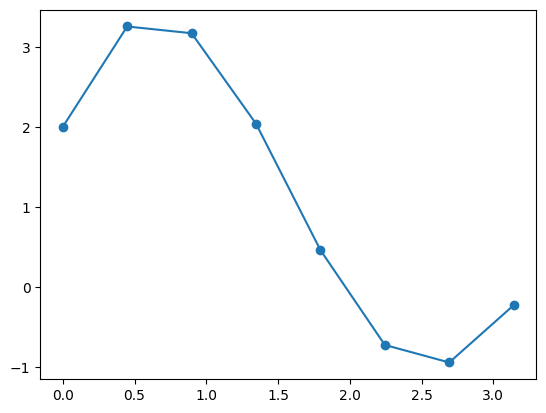

In [61]:
x = np.linspace(0, 10, 11)
y = np.sin(x)
plt.scatter(x_even, y_even)

x_new = np.linspace(0, 10, 201)
plt.plot(x_even, cubic_interpolate(x_even,x_even,y_even))

plt.show()

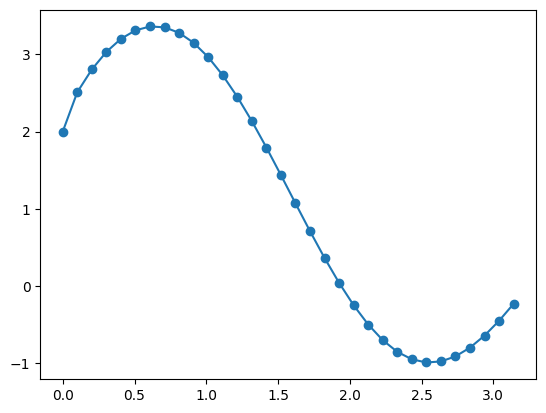

In [62]:
x = even_samples(32)
y = trig(even_samples(32))
plt.scatter(x, y)

x_new = np.linspace(0, 10, 201)
plt.plot(x, cubic_interpolate(x,x,y))

plt.show()

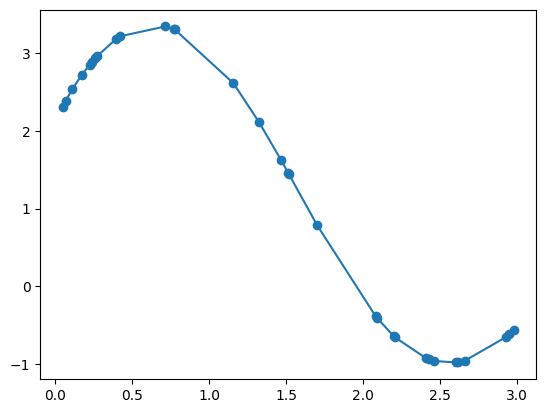

In [63]:
x = ran_samples(32)
x = np.sort(x)
y = trig(x)
plt.scatter(x, y)

x_new = np.linspace(0, 10, 201)
plt.plot(x, cubic_interpolate(x,x,y))

plt.show()

In [64]:
np.sort(x)

array([0.04848685, 0.06715848, 0.11125523, 0.17251927, 0.22269976,
       0.23911835, 0.26017634, 0.27090065, 0.3937662 , 0.42079509,
       0.71383874, 0.77236494, 0.77539899, 1.1571474 , 1.32345678,
       1.4666296 , 1.51414158, 1.5167839 , 1.70211438, 2.0823068 ,
       2.09144687, 2.19920083, 2.20865119, 2.41049038, 2.42767677,
       2.46226358, 2.60223644, 2.61983541, 2.66133683, 2.9276986 ,
       2.95021342, 2.97890664])

---

# Least Squares